In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import env

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Using saas.csv or log data from API usage or store_item_sales

- Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
- Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

## Acquire

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.shape

(790458, 5)

In [5]:
df.Month_Invoiced = pd.to_datetime(df.Month_Invoiced)
df = df.set_index("Month_Invoiced").sort_index()
# df['Month'] = df.index.month
df.head()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [6]:
df.index.max(),df.index.min(), df.index.max() - df.index.min()

(Timestamp('2017-12-31 00:00:00'),
 Timestamp('2014-01-31 00:00:00'),
 Timedelta('1430 days 00:00:00'))

In [7]:
1430 / 4

357.5

In [8]:
df.isna().sum()

Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [9]:
df.index.year.value_counts()

2014    227542
2015    204352
2016    186275
2017    172289
Name: Month_Invoiced, dtype: int64

In [10]:
df.groupby(df.index.day).sum()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
28,52847449421,275631278579,27630.0,138150.0
29,16230363306,87400384855,10391.0,51955.0
30,264755078268,1414667784516,159187.0,795935.0
31,466831941481,2487002081703,276462.0,1382310.0


In [11]:
# df = df[df.Subscription_Type != 0]
# df.head()

- I had initially removed '0' amounts, but later decided to keep them

In [12]:
len(df.index.value_counts())
# these are only end of month values 

48

In [13]:
# train[:100]

In [14]:
df.columns

Index(['Customer_Id', 'Invoice_Id', 'Subscription_Type', 'Amount'], dtype='object')

In [15]:
df = df.drop(columns = ['Customer_Id', 'Invoice_Id', 'Subscription_Type'])
df.head()

,Amount
Month_Invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0


In [16]:
df = df.resample('M').sum()

In [17]:
df.head()

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [18]:
df['Month'] = df.index.month
df.head()

,Amount,Month
Month_Invoiced,,
2014-01-31,35850.0,1
2014-02-28,37190.0,2
2014-03-31,38295.0,3
2014-04-30,39255.0,4
2014-05-31,40355.0,5


In [19]:
# type(df.index)
# df = df.DataFrame(df)
# df = df.set_index("Month_Invoiced").sort_index()
# df['Month'] = df.index.month
# df.head()

In [20]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

## Split
- Making 2014 & 2015 train, 2016 validate, 2017 test:

In [21]:
train = df[:'2015']
validate = df['2016']
test = df['2017']
train.shape, validate.shape, test.shape

((24, 2), (12, 2), (12, 2))

In [22]:
train[-1:], validate[:1], validate[-1:], test[:1]

(                 Amount  Month
 Month_Invoiced                
 2015-12-31      51505.0     12,
                  Amount  Month
 Month_Invoiced                
 2016-01-31      51955.0      1,
                  Amount  Month
 Month_Invoiced                
 2016-12-31      53320.0     12,
                  Amount  Month
 Month_Invoiced                
 2017-01-31      53395.0      1)

- looking good for the splits

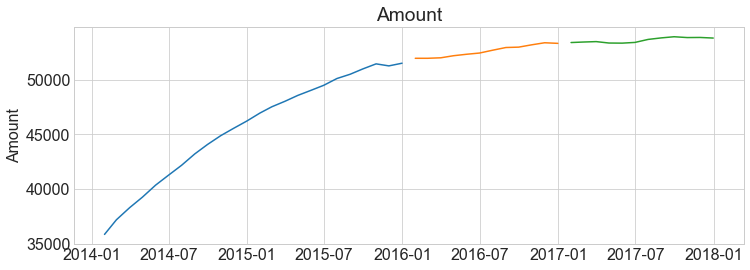

In [23]:
# for col in train.columns:
plt.figure(figsize=(12,4))
plt.plot(train.resample('M').Amount.sum())
plt.plot(validate.resample('M').Amount.sum())
plt.plot(test.resample('M').Amount.sum())
plt.ylabel('Amount')
plt.title('Amount')
plt.show()

## Explo

<AxesSubplot:xlabel='Month_Invoiced'>

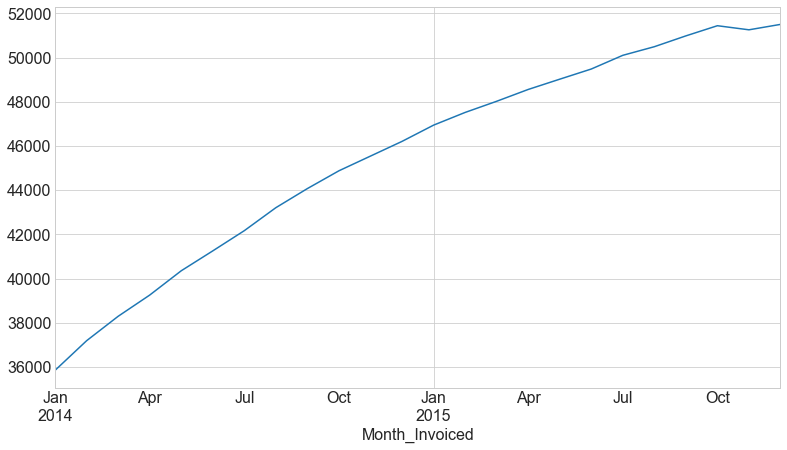

In [26]:
train.Amount.plot()

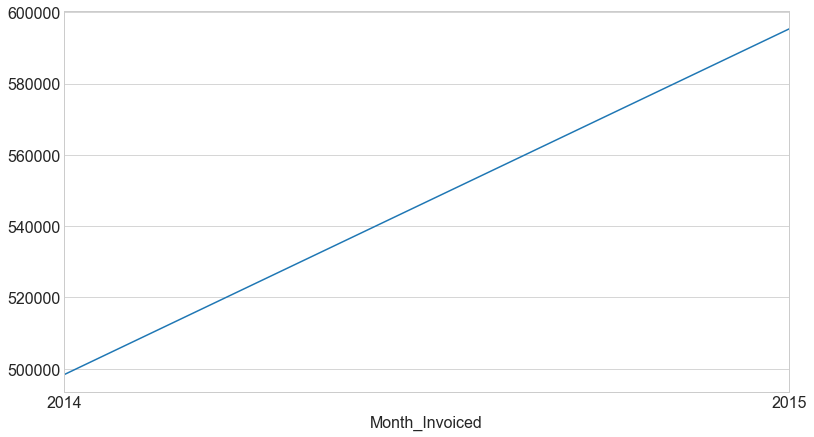

In [27]:
train.resample('Y').Amount.sum().plot();

<AxesSubplot:xlabel='Month_Invoiced'>

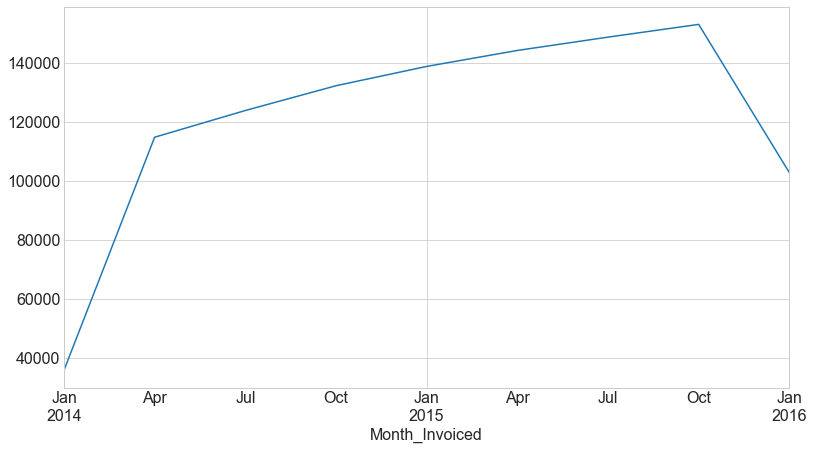

In [28]:
train.resample('3M').Amount.sum().plot()

<AxesSubplot:xlabel='Month_Invoiced'>

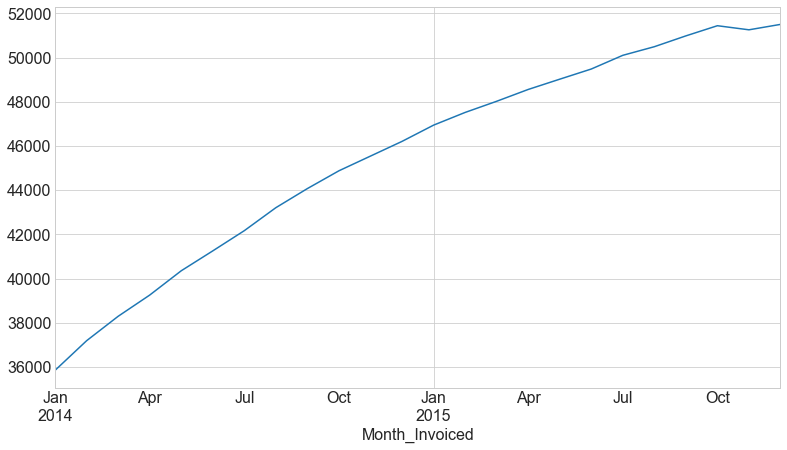

In [29]:
train.resample('M').Amount.sum().plot()

<AxesSubplot:xlabel='Month', ylabel='Amount'>

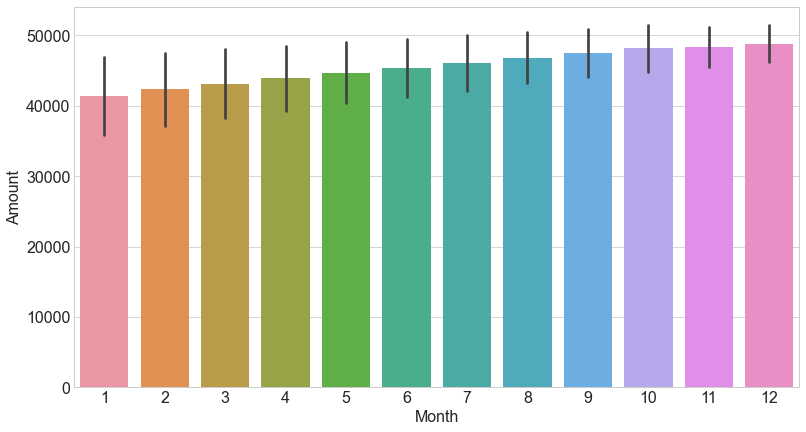

In [30]:
sns.barplot(data=train,x='Month',y='Amount')

[Text(0.5, 1.0, 'Quarterly % Change in Sales Total')]

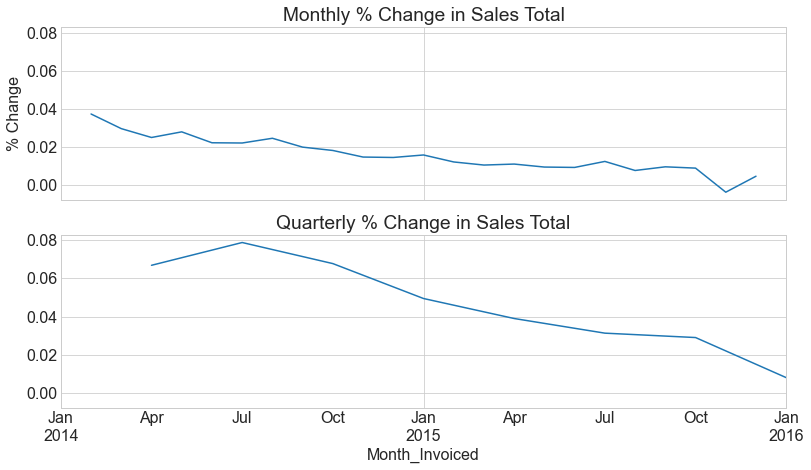

In [47]:
y = train.resample('M').Amount.mean()

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

Monthly = y.resample('M').mean()
(Monthly.diff() / Monthly.shift()).plot(ax=ax1)
ax1.set(title='Monthly % Change in Sales Total', ylabel='% Change', xlabel='')

Quarterly = y.resample('3M').mean()
(Quarterly.diff() / Quarterly.shift()).plot(ax=ax2)
ax2.set(title='Quarterly % Change in Sales Total')
# ax2.hlines(0, *ax2.get_xlim())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

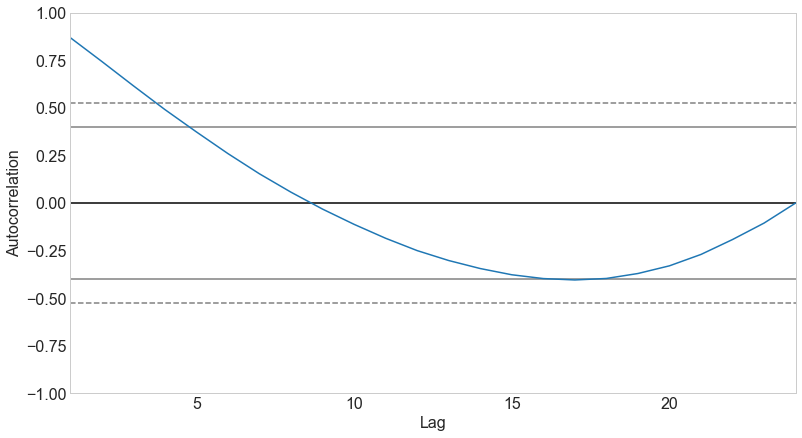

In [48]:
pd.plotting.autocorrelation_plot(y.resample('M').mean())

- this data is mostly noise, isn't it?

#### Decompose:

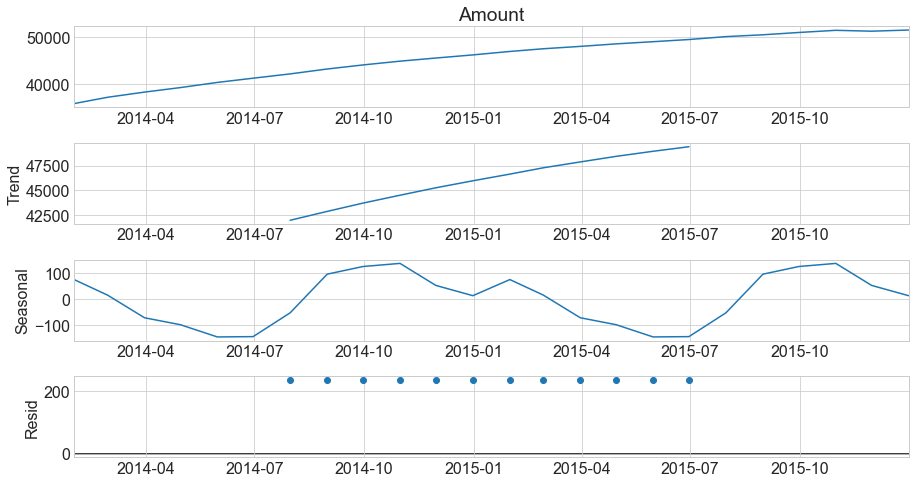

In [49]:
# decompose the data
sm.tsa.seasonal_decompose(y.resample('M').mean()).plot()
None

- wow, there actually is a little apparent seasonality in the data...

## Model

In [50]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [57]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var].resample('M').sum(), label = 'Train', linewidth = 1)
    plt.plot(validate[target_var].resample('M').sum(), label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

### Last Observed Value Method:

In [58]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [59]:
eval_df

,model_type,target_var,rmse


In [60]:
amount = train['Amount'].resample('M').sum()[-1:][0]

yhat_df = pd.DataFrame({'Amount': [amount]}, index = validate.index)

yhat_df.head(2)

,Amount
Month_Invoiced,
2016-01-31,51505.0
2016-02-29,51505.0


- every predicted value is the same in the yhat_df 
- we are using lov method

Amount -- RMSE: 1222


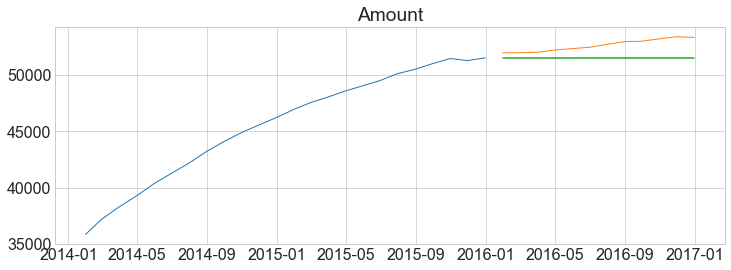

In [61]:
plot_and_eval('Amount')

- Amount -- RMSE: 51502

In [62]:
# Evaluate it:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'Amount')

In [63]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1222.0


### Simple Aveage Method

In [64]:
amount = round(train['Amount'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'Amount': amount}, index = validate.index)

    return yhat_df

yhat_df = make_predictions()

In [65]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


Amount -- RMSE: 7063


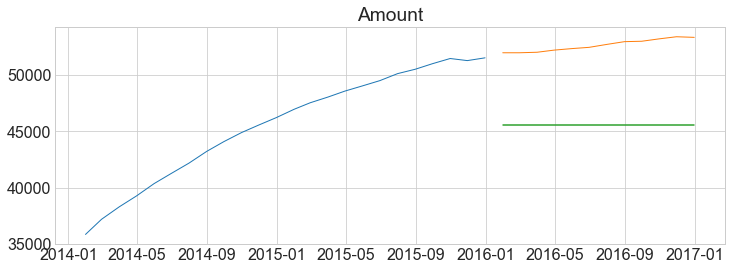

In [66]:
plot_and_eval('Amount')

- Amount -- RMSE: 7063

In [67]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = 'Amount')

In [68]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1222.0
1,simple_average,Amount,7063.0


### Moving Average

In [69]:
# compute a 3 month rolling average, 
# use the most recent/last 3 month period value to predict forward. 

period = 3

amount = train['Amount'].rolling(period).mean().iloc[-1]
# amount = round(train['Amount'].resample('M').rolling(period).mean().iloc[-1], 2)
# amount = round(temp.rolling(period).mean().iloc[-1], 2)



yhat_df = make_predictions()
yhat_df.head(3)

,Amount
Month_Invoiced,
2016-01-31,51403.333333
2016-02-29,51403.333333
2016-03-31,51403.333333


Amount -- RMSE: 1315


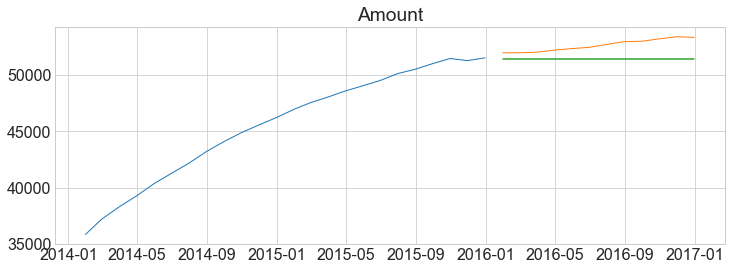

In [70]:
plot_and_eval('Amount')

- 3 month moving average
- Amount -- RMSE: 1315

In [71]:
eval_df = append_eval_df(model_type='3 month moving average', 
                             target_var = 'Amount')

In [72]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1222.0
1,simple_average,Amount,7063.0
2,3 month moving average,Amount,1315.0


In [75]:
# Trying with different periods

periods = [6, 9, 12]

for p in periods:
    amount = round(train['Amount'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Amount'
                            )
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1222.0
1,simple_average,Amount,7063.0
2,3 month moving average,Amount,1315.0
3,6month moving average,Amount,1726.0
4,9month moving average,Amount,2352.0
5,12month moving average,Amount,3044.0


### Trying to extract the best rmse from the eval_df below, will come back

In [79]:
# # get the min rmse for each variable

# min_rmse_Amount_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# # filter only the rows that match those rmse to find out 
# # which models are best thus far
# eval_df[((eval_df.rmse == min_rmse_Amount_sold))]

### Holt's Linear Trend

Amount 



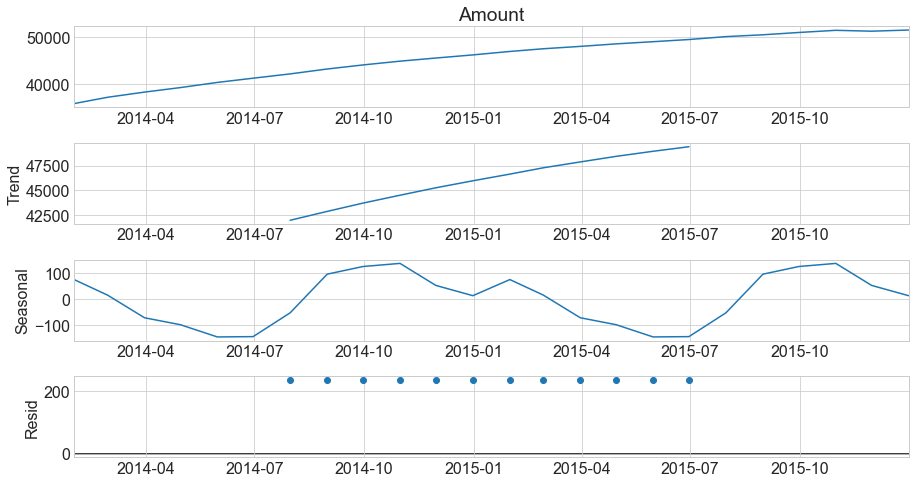

In [80]:
import statsmodels.api as sm
for col in ['Amount']:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [98]:
model = Holt(train['Amount'].resample('M').mean(), exponential = False)
model = model.fit(smoothing_level = .3, 
                  smoothing_slope = .2, 
                  optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['Amount'] = round(yhat_items, 2)



In [99]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-01-31,52502.37
2016-02-29,52894.52
2016-03-31,53286.67
2016-04-30,53678.82
2016-05-31,54070.97


Amount -- RMSE: 2215


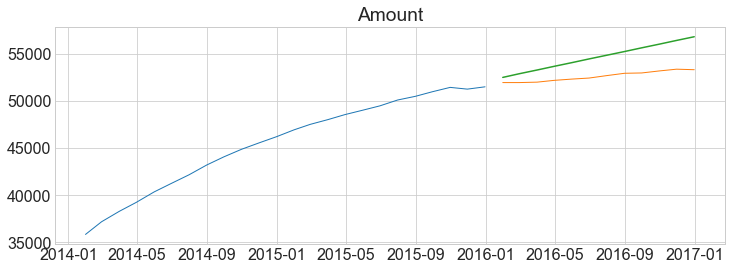

In [100]:
plot_and_eval('Amount')

- Amount -- RMSE: _______

In [101]:
eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = 'Amount')

In [102]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1222.0
1,simple_average,Amount,7063.0
2,3 month moving average,Amount,1315.0
3,6month moving average,Amount,1726.0
4,9month moving average,Amount,2352.0
5,12month moving average,Amount,3044.0
6,Holts,Amount,2541.0
7,Holts,Amount,2215.0


- Holt's with .3 and .2 respectively is a little better on rmse

### Predict on previous cycles...